In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer
import visualkeras


Load Data:

In [2]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.read_csv('Embeddings/ESM_650/train_esm650.csv')
# val = pd.read_csv('Embeddings/ESM_650/val_esm650.csv')
# test = pd.read_csv('Embeddings/ESM_650/test_esm650.csv')

# train = pd.concat([train, val])

# train, val = train_test_split(train, test_size=0.1, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)


# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(935, 1024)
(3226, 1024)
(8411, 20)
(935, 20)
(3226, 20)
(8411, 33)
(935, 33)
(3226, 33)
(8411,)
(935,)
(3226,)


In [3]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [4]:
def plot_roc_pr (title, y_true, y_prob, aucs, auprcs):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(title+'_roc.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(title+'_PR.pdf', format='pdf', bbox_inches='tight')

    plt.show()
    

In [5]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

MLP_32:

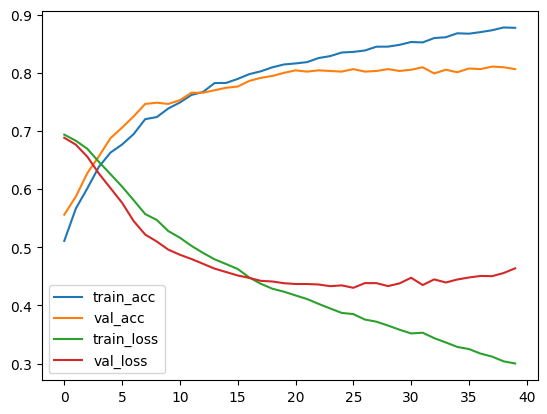

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8064
MCC: 0.6144
AUC: 0.8803
AUPRC: 0.8579
Precision: 0.8380
Recall: 0.7854
Specificity: 0.8299
F1 Score: 0.8109


(0.8064171122994652,
 0.6143961305842291,
 0.8803281096514177,
 0.8578575286434698,
 0.838012958963283,
 0.7854251012145749,
 0.8299319727891157,
 0.8108672936259144)

In [8]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)    
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
# res_model.summary()

# visualkeras.layered_view(res_model, legend=True).show()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=0,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)


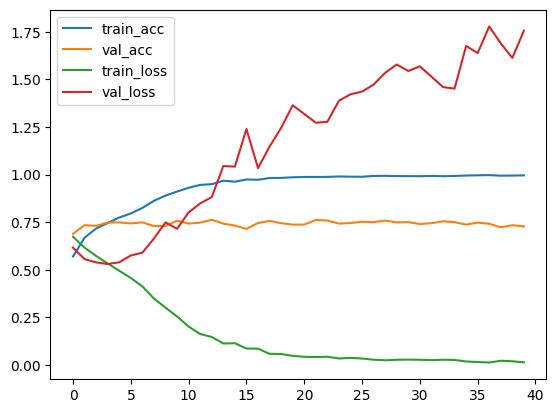

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.7273
MCC: 0.4607
AUC: 0.8057
AUPRC: 0.7797
Precision: 0.7760
Recall: 0.6802
Specificity: 0.7800
F1 Score: 0.7249


(0.7272727272727273,
 0.4607236019704505,
 0.8056840819998714,
 0.7797148893558387,
 0.7759815242494227,
 0.680161943319838,
 0.780045351473923,
 0.7249190938511327)

In [9]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)    
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(2048, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    x_ann = Dense(512, activation='relu')(x_ann)
    x_ann = Dropout(0.3)(x_ann)

    x_ann = Dense(128, activation='relu')(x_ann)
    x_ann = Dropout(0.3)(x_ann)

    x_ann = Dense(32, activation='relu')(x_ann)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
# res_model.summary()

# visualkeras.layered_view(res_model, legend=True).show()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=40, batch_size=64, verbose=0,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, X_val_PSSM= None, y_val = y_val)
